In [1]:
import numpy as np
import meep as mp

Using MPI version 3.1, 1 processes


In [2]:
from Simulations.Tangram.helpers import *
from Simulations.Tangram.parameters import Parameters
from Simulations.Tangram.geometry import GeometryHelper

In [331]:
class Geometry(GeometryHelper):
    
    def __init__(self, parameters):
    
        self.geometry = []
        self.p = parameters
        
        # Materials:
        self.Si = mp.Medium(index=self.p.n_Si)
        self.SiO2 = mp.Medium(index=self.p.n_SiO2)
        self.Fi = mp.Medium(index=2) # fictitious material for debugging purposes
        
        # Calculate grating size:
        a = p.grating_length * p.grating_period # semi-major axis of largest ellipse
        b = a * np.sqrt(1 - p.eccentricity**2) # semi-minor axis of largest ellipse
        e = np.sqrt(a**2 - b**2) # linear eccentricity of largest ellipse
        
        self.grating_size_x = a + e
        self.grating_size_y = self.grating_size_x # quadratic approximation for opening_angle < 90°
        
        # Calculate sandwich size:
        self.sandwich_size_z = p.boxlayer_height + 0.5 * p.devicelayer_height + 1
        
        # Determine geometry extension:
        self.size_x = 0.5 * self.grating_size_x
        self.size_y = 0.5 * self.grating_size_y
        self.size_z = 0.5 * self.sandwich_size_z
        
        # Determine geometry size:
        self.cell_size_z = self.size_z + p.padding[2] + p.pml_thickness
    
    def make_production_geometry(self):
        
        self.shift_center = mp.Vector3(0, 0, self.sandwich_size_z / 2 - 1 )
        self.focal_point = mp.Vector3(- 0.5 * self.grating_size_x, 0, 0)
        
        #######################
        ### Create Geometry ###
        #######################
        
        # Make grating:
        
        for i in range(p.grating_length,p.grating_start,-1):
            
            a = i * p.grating_period
            b = a * np.sqrt(1 - p.eccentricity**2)
            e = np.sqrt(a**2 - b**2)
            elpsd_si = mp.Ellipsoid(size=2*mp.Vector3(a, b, mp.inf),
                                 center=self.shift_center + self.focal_point + mp.Vector3(e, 0, 0),
                                 material=self.Si)
            self.geometry.append(elpsd_si)
            
            a = (i - p.duty_cycle) * p.grating_period
            b = a * np.sqrt(1 - p.eccentricity**2)
            e = np.sqrt(a**2 - b**2)
            elpsd_air = mp.Ellipsoid(size=2*mp.Vector3(a, b, mp.inf),
                                 center=self.shift_center + self.focal_point + mp.Vector3(e, 0, 0),
                                 material=mp.air)
            self.geometry.append(elpsd_air)
            
        # Add wedge-shaped "taper":
    
        a = p.grating_start * p.grating_period
        b = a * np.sqrt(1 - p.eccentricity**2)
        e = np.sqrt(a**2 - b**2)
        elpsd_si = mp.Ellipsoid(size=2*mp.Vector3(a, b, mp.inf),
                             center=self.shift_center + self.focal_point + mp.Vector3(e, 0, 0),
                             material=self.Si)
        self.geometry.append(elpsd_si)
           
        # Add BOX layer:
        box_layer = mp.Block(size=mp.Vector3(mp.inf, mp.inf, p.boxlayer_height),
                                      center=self.shift_center + mp.Vector3(0, 0, -0.5*(p.devicelayer_height + p.boxlayer_height)),
                                      material=self.SiO2)
        self.geometry.append(box_layer)
        
        # Remove superfluous stuff:
        air = (mp.Block(size=mp.Vector3(mp.inf, mp.inf, self.cell_size_z),
                                      center=self.shift_center + mp.Vector3(0, 0, 0.5*(p.devicelayer_height + self.cell_size_z)),
                                      material=mp.air))
        self.geometry.append(air)
        
        # Add Si underlayer:
        underlayer_height = p.padding[0] + p.pml_thickness
        
        underlayer = mp.Block(size=mp.Vector3(mp.inf, mp.inf, underlayer_height),
                                      center=self.shift_center + mp.Vector3(0, 0, -0.5 * (p.devicelayer_height + underlayer_height) - p.boxlayer_height),
                                      material=self.Si)
        self.geometry.append(underlayer)
        
        # Restrict GC to a certain angle:
        wedge = mp.Wedge(center=self.shift_center + self.focal_point,
                         radius=self.grating_size_x,
                         height=p.devicelayer_height,
                         wedge_angle=np.pi - p.opening_angle / 2, # this is super weird
                         wedge_start=mp.Vector3(-1.0, 0.0, 0.0),
                         material=mp.air)
        self.geometry.append(wedge)
        
        # Access waveguide:
        waveguide_offset = 0.5 * p.waveguide_width / np.tan(p.opening_angle / 2)
        waveguide_length = p.padding[0] + p.pml_thickness + waveguide_offset
        waveguide = mp.Block(size=mp.Vector3(waveguide_length, self.p.waveguide_width, self.p.devicelayer_height),
                             center=self.shift_center + self.focal_point - mp.Vector3(0.5 * waveguide_length - waveguide_offset),
                             material=self.Si)
        self.geometry.append(waveguide)

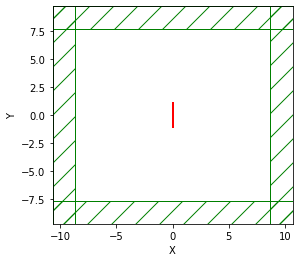

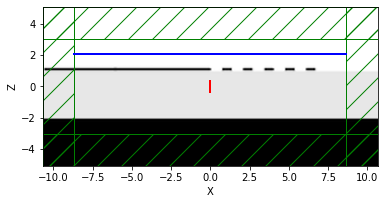

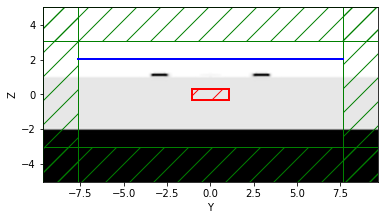

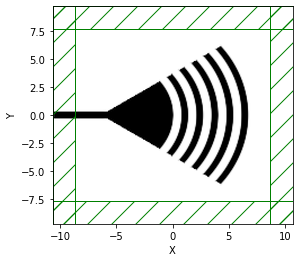

In [337]:
p = Parameters(spatial_resolution=10,
               eccentricity=1/3,
               grating_period=1,
               duty_cycle=0.5,
               grating_length=10,
               grating_start=5,
               opening_angle=np.pi/3,
               padding = [2, 1, 1],
               pml_thickness=2)

geometry = Geometry(p)
geometry.make_production_geometry()

sim, animate = setup_simulation(p, geometry)

nearfield = sim.add_near2far(p.f_center, 0, 1, mp.Near2FarRegion(center=geometry.shift_center + mp.Vector3(0, 0, 1), size=2*mp.Vector3(geometry.size_x + p.padding[0], geometry.size_y + p.padding[1], 0)))

plt.close()

plot_xsections(sim)
plot_xysection(sim, geometry.shift_center)